# Rates Volatility & Yield Curve Analysis (UST ETF Proxies)

**Used Treasury ETF proxies to analyze yield-curve shape dynamics and associated rate volatility regimes.**


Front end: SHY (1–3Y UST)

Belly: IEF (7–10Y UST)

Long end: TLT (20+Y UST)

In [ ]:
#import libraries for data feeds / visualization
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")


In [ ]:
# start pulling treasury ETF proxy data

tickers = ["SHY", "IEF", "TLT"]

data = yf.download(
    tickers,
    start="2010-01-01",
    auto_adjust=True
)["Close"]

data.dropna(inplace=True)
data.tail()


[*********************100%***********************]  3 of 3 completed


Ticker,IEF,SHY,TLT
Date,,,
2026-01-15,96.300003,82.809998,88.309998
2026-01-16,95.930000,82.790001,87.800003
2026-01-20,95.550003,82.800003,86.650002
2026-01-21,95.800003,82.839996,87.309998
2026-01-22,95.720001,82.794998,87.459999


In [ ]:
#Sanity check

returns = data.pct_change().dropna()

returns.describe()


Ticker,IEF,SHY,TLT
count,4037.000000,4037.000000,4037.000000
mean,0.000115,0.000054,0.000152
std,0.004173,0.000841,0.009499
min,-0.025073,-0.005088,-0.066682
25%,-0.002408,-0.000353,-0.005637
50%,0.000219,0.000000,0.000554
75%,0.002596,0.000362,0.005771
max,0.026417,0.009974,0.075196


In [ ]:
# making the actual yield curve

curve = pd.DataFrame(index=data.index)

curve["Long_Short"] = data["TLT"] - data["SHY"]
curve["Belly_Front"] = data["IEF"] - data["SHY"]

curve.dropna(inplace=True)
curve.tail()


,Long_Short,Belly_Front
Date,,
2026-01-15,5.500000,13.490005
2026-01-16,5.010002,13.139999
2026-01-20,3.849998,12.750000
2026-01-21,4.470001,12.960007
2026-01-22,4.665001,12.925003


In [ ]:
# rolling Z scores, classifiying your rate regimes

window = 252  # 1-year rolling window

curve_z = (curve - curve.rolling(window).mean()) / curve.rolling(window).std()
curve_z.dropna(inplace=True)


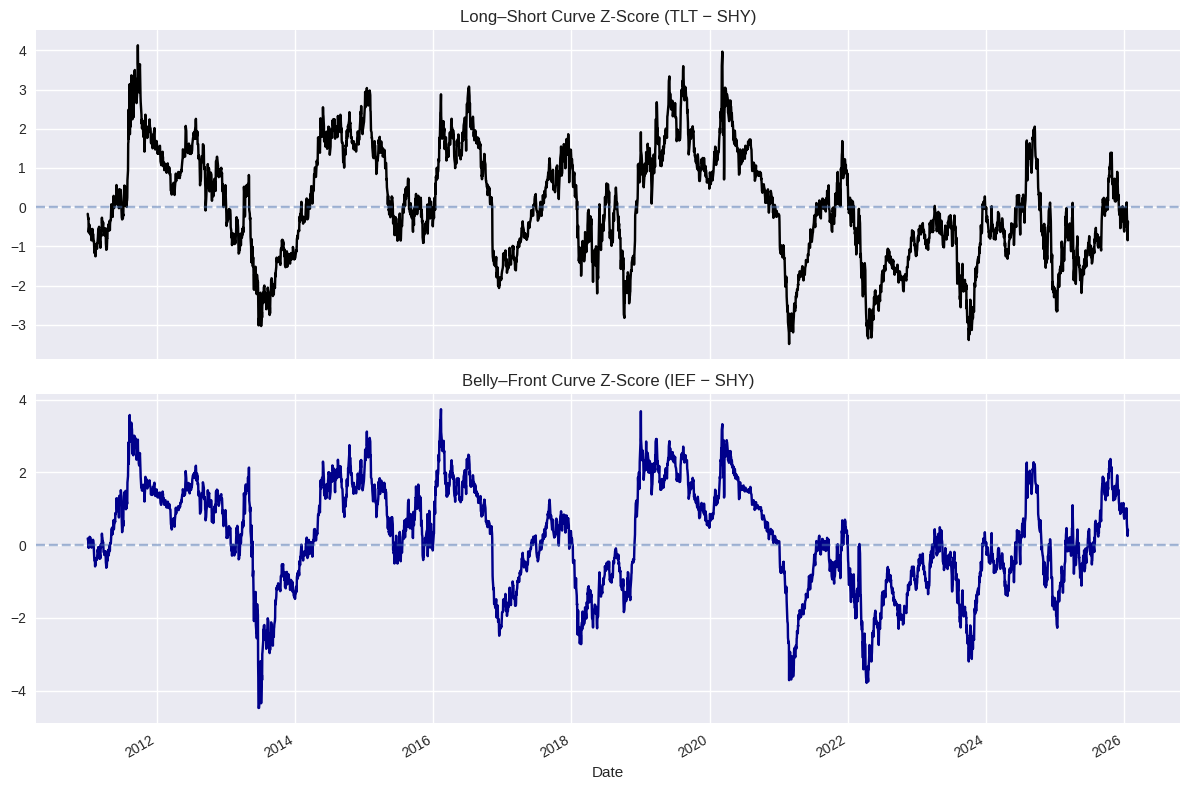

In [ ]:
# visualizing the regime changes

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

curve_z["Long_Short"].plot(ax=ax[0], color="black")
ax[0].axhline(0, linestyle="--", alpha=0.5)
ax[0].set_title("Long–Short Curve Z-Score (TLT − SHY)")

curve_z["Belly_Front"].plot(ax=ax[1], color="darkblue")
ax[1].axhline(0, linestyle="--", alpha=0.5)
ax[1].set_title("Belly–Front Curve Z-Score (IEF − SHY)")

plt.tight_layout()
plt.show()


In [ ]:
# realized rates vol

vol_20d = returns.rolling(20).std() * np.sqrt(252)
vol_60d = returns.rolling(60).std() * np.sqrt(252)


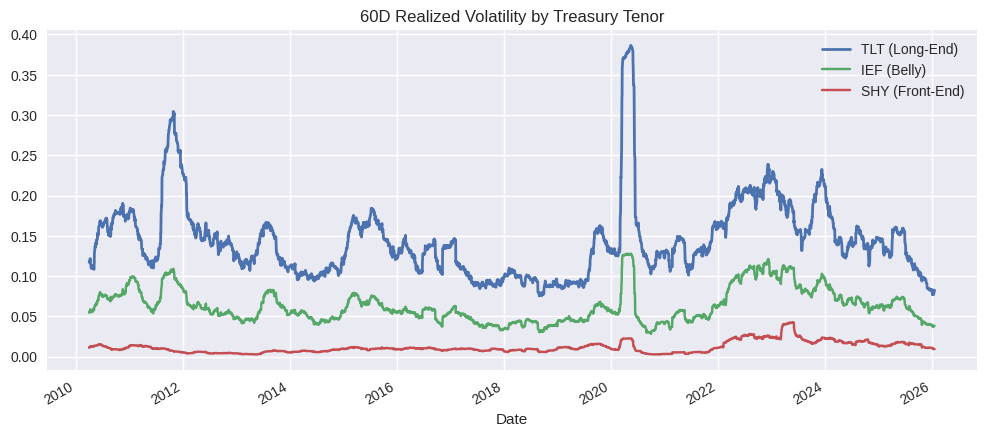

In [ ]:
# vol classification by tenor (expiry)

fig, ax = plt.subplots(figsize=(12, 5))

vol_60d["TLT"].plot(label="TLT (Long-End)", linewidth=2)
vol_60d["IEF"].plot(label="IEF (Belly)")
vol_60d["SHY"].plot(label="SHY (Front-End)")

ax.set_title("60D Realized Volatility by Treasury Tenor")
ax.legend()
plt.show()


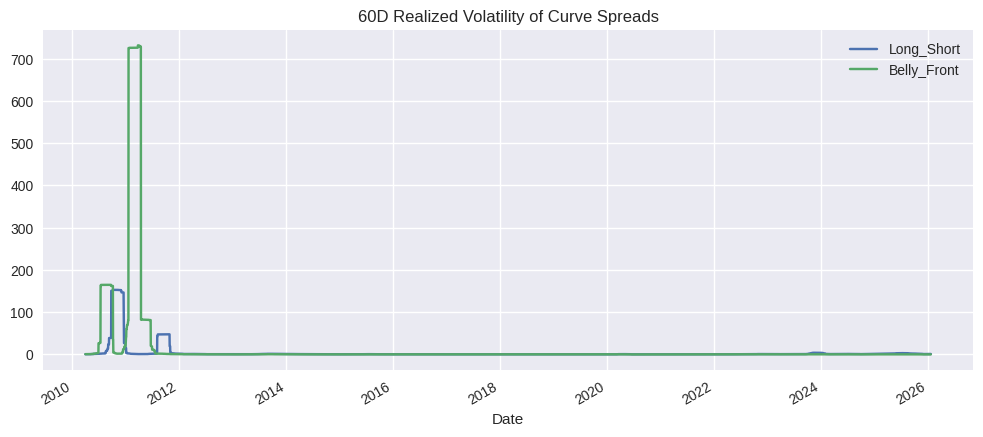

In [ ]:
# spread vol (curve risk volatility)

curve_returns = curve.pct_change().dropna()

curve_vol_60d = curve_returns.rolling(60).std() * np.sqrt(252)


curve_vol_60d.plot(
    figsize=(12, 5),
    title="60D Realized Volatility of Curve Spreads"
)
plt.show()


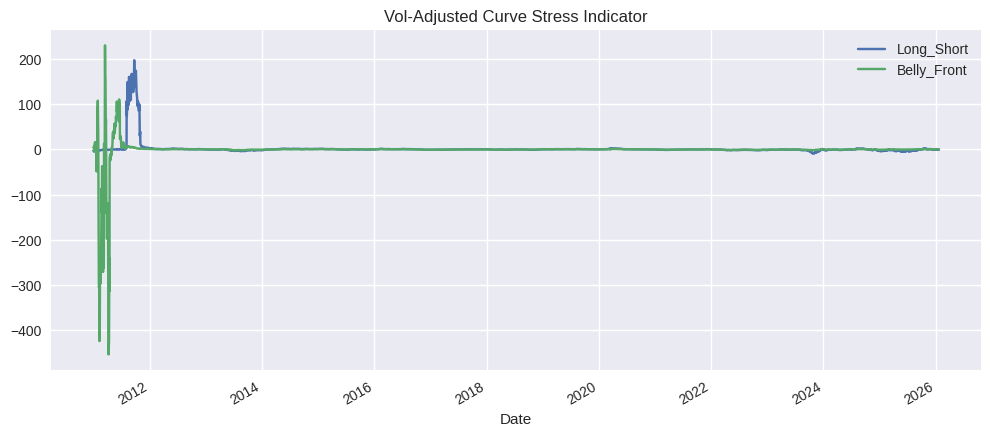

In [ ]:
# curve metrics (Z-score x vol)

curve_stress = curve_z * curve_vol_60d
curve_stress.dropna(inplace=True)

curve_stress.plot(
    figsize=(12, 5),
    title="Vol-Adjusted Curve Stress Indicator"
)
plt.show()


In [ ]:
# volatility by curve regime

regimes = pd.DataFrame(index=curve_z.index)
regimes["Curve_Regime"] = pd.cut(
    curve_z["Long_Short"],
    bins=[-np.inf, -1, 1, np.inf],
    labels=["Flat/Inverted", "Neutral", "Steep"]
)

vol_regime = vol_60d["TLT"].to_frame("TLT_Vol").join(regimes).dropna()

vol_regime.groupby("Curve_Regime").mean()


/tmp/ipython-input-3574806853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_regime.groupby("Curve_Regime").mean()


,TLT_Vol
Curve_Regime,
Flat/Inverted,0.149493
Neutral,0.133379
Steep,0.152406
